# GRU Sentiment Classifier

In this notebook, we use a GRU to classify IMDB movie reviews by their sentiment.

#### Load dependencies

In [1]:
import tensorflow
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, SpatialDropout1D
from tensorflow.keras.layers import GRU # new! 
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 

#### Set hyperparameters

In [2]:
# output directory name:
output_dir = 'model_output/gru'

# training:
epochs = 4
batch_size = 128

# vector-space embedding: 
n_dim = 64 
n_unique_words = 10000 
max_review_length = 100 # lowered due to vanishing gradient over time
pad_type = trunc_type = 'pre'
drop_embed = 0.2 

# GRU layer architecture:
n_gru = 256 
drop_gru = 0.2

#### Load data

In [3]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words) # removed n_words_to_skip

#### Preprocess data

In [4]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

#### Design neural network architecture

In [5]:
model = Sequential()

# First Hidden layer - embeddings: 
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length)) 
model.add(SpatialDropout1D(drop_embed))

# Second Hidden Layer - GRU:
model.add(GRU(n_gru, dropout=drop_gru))

# output Layer:
model.add(Dense(1, activation='sigmoid'))

/Users/sshivagangeprakash/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


#### Configure model

In [6]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [7]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.keras")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Train!

In [8]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Epoch 1/4
196/196 ━━━━━━━━━━━━━━━━━━━━ 82s 415ms/step - accuracy: 0.5578 - loss: 0.6835 - val_accuracy: 0.8262 - val_loss: 0.3857
Epoch 2/4
196/196 ━━━━━━━━━━━━━━━━━━━━ 80s 410ms/step - accuracy: 0.8471 - loss: 0.3510 - val_accuracy: 0.8540 - val_loss: 0.3403
Epoch 3/4
196/196 ━━━━━━━━━━━━━━━━━━━━ 83s 424ms/step - accuracy: 0.9060 - loss: 0.2394 - val_accuracy: 0.8498 - val_loss: 0.3682
Epoch 4/4
196/196 ━━━━━━━━━━━━━━━━━━━━ 83s 422ms/step - accuracy: 0.9299 - loss: 0.1891 - val_accuracy: 0.8486 - val_loss: 0.3570


In [9]:
model.summary() 
# check the parameters count in this cell output, 
# It will be larger than dense neural network, CNN, Simple RNN
# but it will be smaller than LSTM - because GRU cell will have only 3 activation function wheras it is more in LSTM.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 100, 64)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 256)            │       247,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,662,662 (10.16 MB)

 Trainable params: 887,553 (3.39 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,775,109 (6.77 MB)

#### Evaluate

In [10]:
model.load_weights(output_dir+"/weights.02.keras") 

In [11]:
y_hat = model.predict(x_valid)

782/782 ━━━━━━━━━━━━━━━━━━━━ 44s 57ms/step


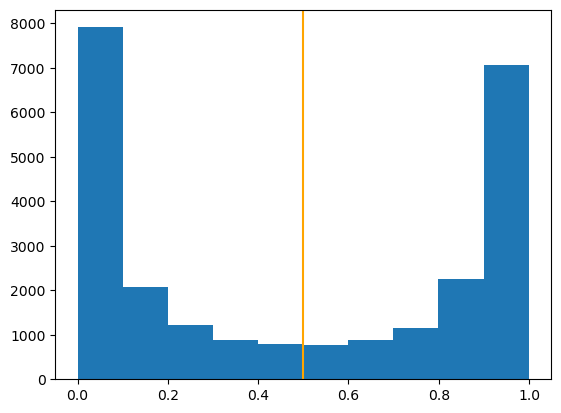

In [12]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [13]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat)*100.0)

'93.09'